In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=4, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [19]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 64
        self.conv2_out_channels = 96
        self.conv3_out_channels = 128
        self.conv4_out_channels = 128
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = 128
        self.fc4_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.LeakyReLU(0.05)          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.LeakyReLU(0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.LeakyReLU(0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.LeakyReLU(0.05)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.291)
        self.act_fc1 = nn.LeakyReLU(0.05)
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.334)
        self.act_fc2 = nn.LeakyReLU(0.05)
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.dropout3 = nn.Dropout(0.3)
        self.act_fc3 = nn.LeakyReLU(0.05)
        
        self.fc4 = nn.Linear(in_features=self.fc3_out_features, out_features=self.fc4_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.dropout3(self.act_fc3(self.fc3(x)))
        x = self.output_activation(self.fc4(x))
        
        return x
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.00046)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)


In [20]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)    

In [21]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [22]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
)

In [23]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc"
    patience=9,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [24]:
# Create logger
logger = TensorBoardLogger("tensorboard_logs", name="miniimagenet_cnn")

In [25]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [26]:
datamodule = DataModule(batch_size=64, num_workers=8)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=100)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 1.8 K  | train
1  | bn1               | BatchNorm2d | 128    | train
2  | act1              | LeakyReLU   | 0      | train
3  | pool1             | MaxPool2d   | 0      | train
4  | conv2             | Conv2d      | 55.4 K | train
5  | bn2               | BatchNorm2d | 192    | train
6  | act2              | LeakyReLU   | 0      | train
7  | pool2             | MaxPool2d   | 0      | train
8  | conv3             | Conv2d      | 110 K  | train
9  | bn3               | BatchNorm2d | 256    | train
10 | act3              | LeakyReLU   | 0      | train
11 | pool3             | MaxPool2d   | 0      | train
12 | conv4             | Conv2d      | 147 K  | train
13 | bn4               | 

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.44it/s]
Val - After Epoch 0: loss=3.917, acc=0.000
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 329/329 [01:36<00:00,  3.41it/s, v_num=13]
Val - After Epoch 0: loss=3.583, acc=0.081
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 329/329 [01:59<00:00,  2.76it/s, v_num=13]

Metric val_loss improved. New best score: 3.583



Train - After Epoch 0: loss=3.796, acc=0.048
Learning rate after epoch 0: 0.00046
[Epoch 0] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:29<00:00,  0.84it/s, v_num=13]
Val - After Epoch 1: loss=3.425, acc=0.116
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 3.425



Train - After Epoch 1: loss=3.558, acc=0.090
Learning rate after epoch 1: 0.00046
[Epoch 1] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:27<00:00,  0.85it/s, v_num=13]
Val - After Epoch 2: loss=3.289, acc=0.154
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:49<00:00,  0.80it/s, v_num=13]

Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 3.289



Train - After Epoch 2: loss=3.407, acc=0.118
Learning rate after epoch 2: 0.00046
[Epoch 2] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 3: loss=3.201, acc=0.172
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:47<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 3.201



Train - After Epoch 3: loss=3.294, acc=0.145
Learning rate after epoch 3: 0.00046
[Epoch 3] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 4: loss=3.043, acc=0.206
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:47<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 3.043



Train - After Epoch 4: loss=3.194, acc=0.168
Learning rate after epoch 4: 0.00046
[Epoch 4] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:27<00:00,  0.85it/s, v_num=13]
Val - After Epoch 5: loss=3.092, acc=0.198
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]
Train - After Epoch 5: loss=3.120, acc=0.186
Learning rate after epoch 5: 0.00046
[Epoch 5] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:23<00:00,  0.86it/s, v_num=13]
Val - After Epoch 6: loss=2.959, acc=0.222
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:43<00:00,  0.82it/s, v_num=13]

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 2.959



Train - After Epoch 6: loss=3.047, acc=0.197
Learning rate after epoch 6: 0.00046
[Epoch 6] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:23<00:00,  0.86it/s, v_num=13]
Val - After Epoch 7: loss=2.892, acc=0.240
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:43<00:00,  0.82it/s, v_num=13]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 2.892



Train - After Epoch 7: loss=2.987, acc=0.213
Learning rate after epoch 7: 0.00046
[Epoch 7] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:25<00:00,  0.85it/s, v_num=13]
Val - After Epoch 8: loss=2.809, acc=0.261
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 2.809



Train - After Epoch 8: loss=2.929, acc=0.231
Learning rate after epoch 8: 0.00046
[Epoch 8] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 9: loss=2.789, acc=0.270
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 2.789



Train - After Epoch 9: loss=2.870, acc=0.241
Learning rate after epoch 9: 0.00046
[Epoch 9] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 10: 100%|████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 10: loss=2.737, acc=0.277
Epoch 10: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 2.737



Train - After Epoch 10: loss=2.818, acc=0.256
Learning rate after epoch 10: 0.00046
[Epoch 10] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 11: 100%|████████████████████████████████████████████████████████████| 329/329 [06:22<00:00,  0.86it/s, v_num=13]
Val - After Epoch 11: loss=2.631, acc=0.296
Epoch 11: 100%|████████████████████████████████████████████████████████████| 329/329 [06:43<00:00,  0.82it/s, v_num=13]

Metric val_loss improved by 0.107 >= min_delta = 0.0. New best score: 2.631



Train - After Epoch 11: loss=2.764, acc=0.269
Learning rate after epoch 11: 0.00046
[Epoch 11] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 12: 100%|████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 12: loss=2.617, acc=0.301
Epoch 12: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 2.617



Train - After Epoch 12: loss=2.726, acc=0.277
Learning rate after epoch 12: 0.00046
[Epoch 12] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 13: 100%|████████████████████████████████████████████████████████████| 329/329 [06:25<00:00,  0.85it/s, v_num=13]
Val - After Epoch 13: loss=2.574, acc=0.321
Epoch 13: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 2.574



Train - After Epoch 13: loss=2.678, acc=0.290
Learning rate after epoch 13: 0.00046
[Epoch 13] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 14: 100%|████████████████████████████████████████████████████████████| 329/329 [06:25<00:00,  0.85it/s, v_num=13]
Val - After Epoch 14: loss=2.592, acc=0.312
Epoch 14: 100%|████████████████████████████████████████████████████████████| 329/329 [06:45<00:00,  0.81it/s, v_num=13]
Train - After Epoch 14: loss=2.643, acc=0.290
Learning rate after epoch 14: 0.00046
[Epoch 14] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 15: 100%|████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 15: loss=2.561, acc=0.322
Epoch 15: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 2.561



Train - After Epoch 15: loss=2.606, acc=0.304
Learning rate after epoch 15: 0.00046
[Epoch 15] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 16: 100%|████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 16: loss=2.540, acc=0.325
Epoch 16: 100%|████████████████████████████████████████████████████████████| 329/329 [06:48<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 2.540



Train - After Epoch 16: loss=2.583, acc=0.316
Learning rate after epoch 16: 0.00046
[Epoch 16] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 17: 100%|████████████████████████████████████████████████████████████| 329/329 [06:27<00:00,  0.85it/s, v_num=13]
Val - After Epoch 17: loss=2.473, acc=0.343
Epoch 17: 100%|████████████████████████████████████████████████████████████| 329/329 [06:48<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 2.473



Train - After Epoch 17: loss=2.556, acc=0.317
Learning rate after epoch 17: 0.00046
[Epoch 17] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 18: 100%|████████████████████████████████████████████████████████████| 329/329 [06:25<00:00,  0.85it/s, v_num=13]
Val - After Epoch 18: loss=2.426, acc=0.347
Epoch 18: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 2.426



Train - After Epoch 18: loss=2.516, acc=0.327
Learning rate after epoch 18: 0.00046
[Epoch 18] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 19: 100%|████████████████████████████████████████████████████████████| 329/329 [06:26<00:00,  0.85it/s, v_num=13]
Val - After Epoch 19: loss=2.468, acc=0.337
Epoch 19: 100%|████████████████████████████████████████████████████████████| 329/329 [06:46<00:00,  0.81it/s, v_num=13]
Train - After Epoch 19: loss=2.499, acc=0.330
Learning rate after epoch 19: 0.00046
[Epoch 19] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 20: 100%|████████████████████████████████████████████████████████████| 329/329 [06:31<00:00,  0.84it/s, v_num=13]
Val - After Epoch 20: loss=2.446, acc=0.347
Epoch 20: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Train - After Epoch 20: loss=2.462, acc=0.340
Learning rate after epoch 20: 0.00046
[Epoch 20] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 2.381



Train - After Epoch 22: loss=2.409, acc=0.347
Learning rate after epoch 22: 0.00046
[Epoch 22] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 23: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Val - After Epoch 23: loss=2.440, acc=0.349
Epoch 23: 100%|████████████████████████████████████████████████████████████| 329/329 [07:11<00:00,  0.76it/s, v_num=13]
Train - After Epoch 23: loss=2.378, acc=0.354
Learning rate after epoch 23: 0.00046
[Epoch 23] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 24: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 24: loss=2.356, acc=0.367
Epoch 24: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 2.356



Train - After Epoch 24: loss=2.373, acc=0.362
Learning rate after epoch 24: 0.00046
[Epoch 24] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 25: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 25: loss=2.309, acc=0.379
Epoch 25: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 2.309



Train - After Epoch 25: loss=2.344, acc=0.367
Learning rate after epoch 25: 0.00046
[Epoch 25] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 26: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 26: loss=2.281, acc=0.385
Epoch 26: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 2.281



Train - After Epoch 26: loss=2.319, acc=0.365
Learning rate after epoch 26: 0.00046
[Epoch 26] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 27: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 27: loss=2.264, acc=0.385
Epoch 27: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 2.264



Train - After Epoch 27: loss=2.307, acc=0.374
Learning rate after epoch 27: 0.00046
[Epoch 27] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 28: 100%|████████████████████████████████████████████████████████████| 329/329 [06:49<00:00,  0.80it/s, v_num=13]
Val - After Epoch 28: loss=2.349, acc=0.374
Epoch 28: 100%|████████████████████████████████████████████████████████████| 329/329 [07:09<00:00,  0.77it/s, v_num=13]
Train - After Epoch 28: loss=2.270, acc=0.384
Learning rate after epoch 28: 0.00046
[Epoch 28] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 29: 100%|████████████████████████████████████████████████████████████| 329/329 [06:54<00:00,  0.79it/s, v_num=13]
Val - After Epoch 29: loss=2.272, acc=0.390
Epoch 29: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 29: loss=2.254, acc=0.386
Learning rate after epoch 29: 0.00046
[Epoch 29] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 2.177



Train - After Epoch 31: loss=2.226, acc=0.394
Learning rate after epoch 31: 0.00046
[Epoch 31] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 32: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Val - After Epoch 32: loss=2.341, acc=0.383
Epoch 32: 100%|████████████████████████████████████████████████████████████| 329/329 [07:11<00:00,  0.76it/s, v_num=13]
Train - After Epoch 32: loss=2.205, acc=0.400
Learning rate after epoch 32: 0.00046
[Epoch 32] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 33: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 33: loss=2.310, acc=0.375
Epoch 33: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 33: loss=2.191, acc=0.404
Learning rate after epoch 33: 0.00046
[Epoch 33] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 2.149



Train - After Epoch 34: loss=2.160, acc=0.413
Learning rate after epoch 34: 0.00046
[Epoch 34] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 35: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 35: loss=2.128, acc=0.419
Epoch 35: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 2.128



Train - After Epoch 35: loss=2.158, acc=0.410
Learning rate after epoch 35: 0.00046
[Epoch 35] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 36: 100%|████████████████████████████████████████████████████████████| 329/329 [06:50<00:00,  0.80it/s, v_num=13]
Val - After Epoch 36: loss=2.159, acc=0.412
Epoch 36: 100%|████████████████████████████████████████████████████████████| 329/329 [07:10<00:00,  0.76it/s, v_num=13]
Train - After Epoch 36: loss=2.137, acc=0.414
Learning rate after epoch 36: 0.00046
[Epoch 36] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 37: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 37: loss=2.162, acc=0.417
Epoch 37: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 37: loss=2.136, acc=0.414
Learning rate after epoch 37: 0.00046
[Epoch 37] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 2.093



Train - After Epoch 38: loss=2.106, acc=0.423
Learning rate after epoch 38: 0.00046
[Epoch 38] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 39: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 39: loss=2.071, acc=0.431
Epoch 39: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.071



Train - After Epoch 39: loss=2.089, acc=0.430
Learning rate after epoch 39: 0.00046
[Epoch 39] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 40: 100%|████████████████████████████████████████████████████████████| 329/329 [06:50<00:00,  0.80it/s, v_num=13]
Val - After Epoch 40: loss=2.108, acc=0.432
Epoch 40: 100%|████████████████████████████████████████████████████████████| 329/329 [07:10<00:00,  0.76it/s, v_num=13]
Train - After Epoch 40: loss=2.074, acc=0.429
Learning rate after epoch 40: 0.00046
[Epoch 40] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 41: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 41: loss=2.193, acc=0.405
Epoch 41: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 41: loss=2.056, acc=0.437
Learning rate after epoch 41: 0.00046
[Epoch 41] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.037



Train - After Epoch 42: loss=2.046, acc=0.440
Learning rate after epoch 42: 0.00046
[Epoch 42] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 43: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 43: loss=2.079, acc=0.440
Epoch 43: 100%|████████████████████████████████████████████████████████████| 329/329 [07:14<00:00,  0.76it/s, v_num=13]
Train - After Epoch 43: loss=2.029, acc=0.441
Learning rate after epoch 43: 0.00046
[Epoch 43] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 44: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 44: loss=2.005, acc=0.460
Epoch 44: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 2.005



Train - After Epoch 44: loss=2.021, acc=0.447
Learning rate after epoch 44: 0.00046
[Epoch 44] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 45: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 45: loss=2.047, acc=0.452
Epoch 45: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 45: loss=2.000, acc=0.450
Learning rate after epoch 45: 0.00046
[Epoch 45] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 46: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 46: loss=2.013, acc=0.448
Epoch 46: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 46: loss=2.008, acc=0.452
Learning rate after epoch 46: 0.00046
[Epoch 46] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.917



Train - After Epoch 49: loss=1.868, acc=0.482
Learning rate after epoch 49: 0.00023
[Epoch 49] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 50: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 50: loss=1.904, acc=0.482
Epoch 50: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.904



Train - After Epoch 50: loss=1.858, acc=0.484
Learning rate after epoch 50: 0.00023
[Epoch 50] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 51: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 51: loss=1.909, acc=0.479
Epoch 51: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 51: loss=1.822, acc=0.492
Learning rate after epoch 51: 0.00023
[Epoch 51] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 52: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 52: loss=1.911, acc=0.479
Epoch 52: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 52: loss=1.840, acc=0.493
Learning rate after epoch 52: 0.00023
[Epoch 52] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.896



Train - After Epoch 53: loss=1.810, acc=0.495
Learning rate after epoch 53: 0.00023
[Epoch 53] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 54: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 54: loss=1.884, acc=0.487
Epoch 54: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.884



Train - After Epoch 54: loss=1.799, acc=0.492
Learning rate after epoch 54: 0.00023
[Epoch 54] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 55: 100%|████████████████████████████████████████████████████████████| 329/329 [06:50<00:00,  0.80it/s, v_num=13]
Val - After Epoch 55: loss=1.897, acc=0.483
Epoch 55: 100%|████████████████████████████████████████████████████████████| 329/329 [07:09<00:00,  0.77it/s, v_num=13]
Train - After Epoch 55: loss=1.794, acc=0.502
Learning rate after epoch 55: 0.00023
[Epoch 55] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 56: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 56: loss=1.853, acc=0.491
Epoch 56: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.853



Train - After Epoch 56: loss=1.772, acc=0.507
Learning rate after epoch 56: 0.00023
[Epoch 56] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 57: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Val - After Epoch 57: loss=1.888, acc=0.487
Epoch 57: 100%|████████████████████████████████████████████████████████████| 329/329 [07:11<00:00,  0.76it/s, v_num=13]
Train - After Epoch 57: loss=1.780, acc=0.501
Learning rate after epoch 57: 0.00023
[Epoch 57] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 58: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 58: loss=1.880, acc=0.484
Epoch 58: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 58: loss=1.772, acc=0.507
Learning rate after epoch 58: 0.00023
[Epoch 58] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.842



Train - After Epoch 59: loss=1.756, acc=0.512
Learning rate after epoch 59: 0.00023
[Epoch 59] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 60: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 60: loss=1.860, acc=0.493
Epoch 60: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 60: loss=1.755, acc=0.512
Learning rate after epoch 60: 0.00023
[Epoch 60] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 61: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Val - After Epoch 61: loss=1.897, acc=0.491
Epoch 61: 100%|████████████████████████████████████████████████████████████| 329/329 [07:11<00:00,  0.76it/s, v_num=13]
Train - After Epoch 61: loss=1.749, acc=0.513
Learning rate after epoch 61: 0.00023
[Epoch 61] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.833



Train - After Epoch 62: loss=1.728, acc=0.513
Learning rate after epoch 62: 0.00023
[Epoch 62] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 63: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 63: loss=1.865, acc=0.494
Epoch 63: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 63: loss=1.724, acc=0.515
Learning rate after epoch 63: 0.00023
[Epoch 63] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 64: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 64: loss=1.876, acc=0.487
Epoch 64: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 64: loss=1.722, acc=0.517
Learning rate after epoch 64: 0.00023
[Epoch 64] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.823



Train - After Epoch 65: loss=1.713, acc=0.517
Learning rate after epoch 65: 0.00023
[Epoch 65] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 66: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 66: loss=1.832, acc=0.502
Epoch 66: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 66: loss=1.698, acc=0.522
Learning rate after epoch 66: 0.00023
[Epoch 66] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 67: 100%|████████████████████████████████████████████████████████████| 329/329 [06:51<00:00,  0.80it/s, v_num=13]
Val - After Epoch 67: loss=1.835, acc=0.499
Epoch 67: 100%|████████████████████████████████████████████████████████████| 329/329 [07:10<00:00,  0.76it/s, v_num=13]
Train - After Epoch 67: loss=1.694, acc=0.521
Learning rate after epoch 67: 0.00023
[Epoch 67] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.776



Train - After Epoch 70: loss=1.637, acc=0.536
Learning rate after epoch 70: 0.000115
[Epoch 70] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 71: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 71: loss=1.764, acc=0.520
Epoch 71: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.764



Train - After Epoch 71: loss=1.625, acc=0.541
Learning rate after epoch 71: 0.000115
[Epoch 71] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 72: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 72: loss=1.753, acc=0.516
Epoch 72: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.753



Train - After Epoch 72: loss=1.617, acc=0.546
Learning rate after epoch 72: 0.000115
[Epoch 72] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 73: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 73: loss=1.781, acc=0.512
Epoch 73: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 73: loss=1.609, acc=0.546
Learning rate after epoch 73: 0.000115
[Epoch 73] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 74: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 74: loss=1.760, acc=0.521
Epoch 74: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 74: loss=1.608, acc=0.547
Learning rate after epoch 74: 0.000115
[Epoch 74] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.738



Train - After Epoch 76: loss=1.592, acc=0.549
Learning rate after epoch 76: 0.000115
[Epoch 76] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 77: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 77: loss=1.760, acc=0.520
Epoch 77: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 77: loss=1.587, acc=0.550
Learning rate after epoch 77: 0.000115
[Epoch 77] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 78: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 78: loss=1.751, acc=0.525
Epoch 78: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 78: loss=1.586, acc=0.556
Learning rate after epoch 78: 0.000115
[Epoch 78] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.734



Train - After Epoch 79: loss=1.590, acc=0.553
Learning rate after epoch 79: 0.000115
[Epoch 79] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 80: 100%|████████████████████████████████████████████████████████████| 329/329 [06:50<00:00,  0.80it/s, v_num=13]
Val - After Epoch 80: loss=1.751, acc=0.519
Epoch 80: 100%|████████████████████████████████████████████████████████████| 329/329 [07:10<00:00,  0.76it/s, v_num=13]
Train - After Epoch 80: loss=1.576, acc=0.557
Learning rate after epoch 80: 0.000115
[Epoch 80] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 81: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 81: loss=1.755, acc=0.523
Epoch 81: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 81: loss=1.566, acc=0.559
Learning rate after epoch 81: 0.000115
[Epoch 81] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.723



Train - After Epoch 84: loss=1.537, acc=0.566
Learning rate after epoch 84: 5.75e-05
[Epoch 84] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 85: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 85: loss=1.731, acc=0.528
Epoch 85: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]
Train - After Epoch 85: loss=1.532, acc=0.568
Learning rate after epoch 85: 5.75e-05
[Epoch 85] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 86: 100%|████████████████████████████████████████████████████████████| 329/329 [06:50<00:00,  0.80it/s, v_num=13]
Val - After Epoch 86: loss=1.749, acc=0.525
Epoch 86: 100%|████████████████████████████████████████████████████████████| 329/329 [07:10<00:00,  0.76it/s, v_num=13]
Train - After Epoch 86: loss=1.512, acc=0.572
Learning rate after epoch 86: 5.75e-05
[Epoch 86] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.697



Train - After Epoch 89: loss=1.508, acc=0.572
Learning rate after epoch 89: 2.875e-05
[Epoch 89] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 90: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 90: loss=1.714, acc=0.534
Epoch 90: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 90: loss=1.498, acc=0.574
Learning rate after epoch 90: 2.875e-05
[Epoch 90] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 91: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 91: loss=1.707, acc=0.542
Epoch 91: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 91: loss=1.499, acc=0.576
Learning rate after epoch 91: 2.875e-05
[Epoch 91] Grad Norms — Total: 24, Vanished: 3, Explo

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.696



Train - After Epoch 97: loss=1.487, acc=0.579
Learning rate after epoch 97: 1.4375e-05
[Epoch 97] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 98: 100%|████████████████████████████████████████████████████████████| 329/329 [06:53<00:00,  0.80it/s, v_num=13]
Val - After Epoch 98: loss=1.722, acc=0.531
Epoch 98: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]
Train - After Epoch 98: loss=1.489, acc=0.575
Learning rate after epoch 98: 1.4375e-05
[Epoch 98] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 99: 100%|████████████████████████████████████████████████████████████| 329/329 [06:52<00:00,  0.80it/s, v_num=13]
Val - After Epoch 99: loss=1.687, acc=0.539
Epoch 99: 100%|████████████████████████████████████████████████████████████| 329/329 [07:12<00:00,  0.76it/s, v_num=13]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.687



Train - After Epoch 99: loss=1.492, acc=0.572
Learning rate after epoch 99: 1.4375e-05
[Epoch 99] Grad Norms — Total: 24, Vanished: 3, Exploded: 0


`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████| 329/329 [07:13<00:00,  0.76it/s, v_num=13]


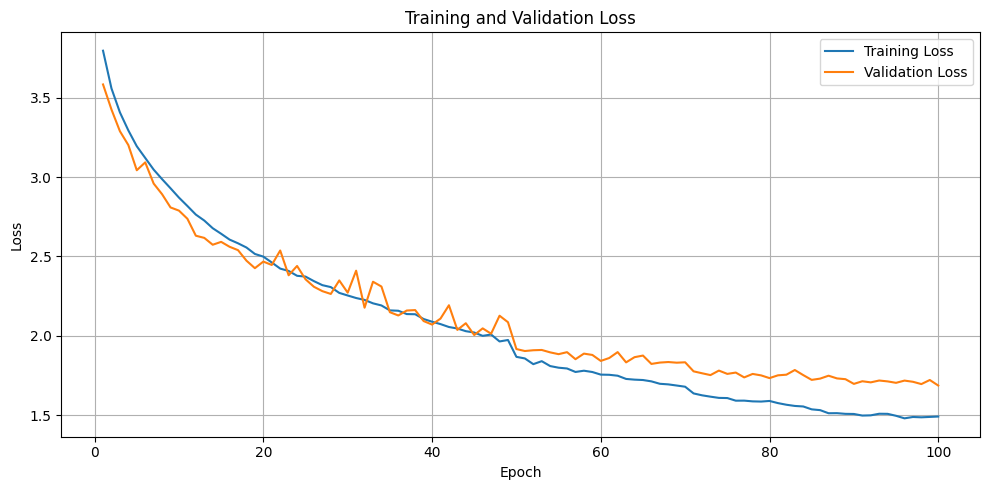

In [27]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

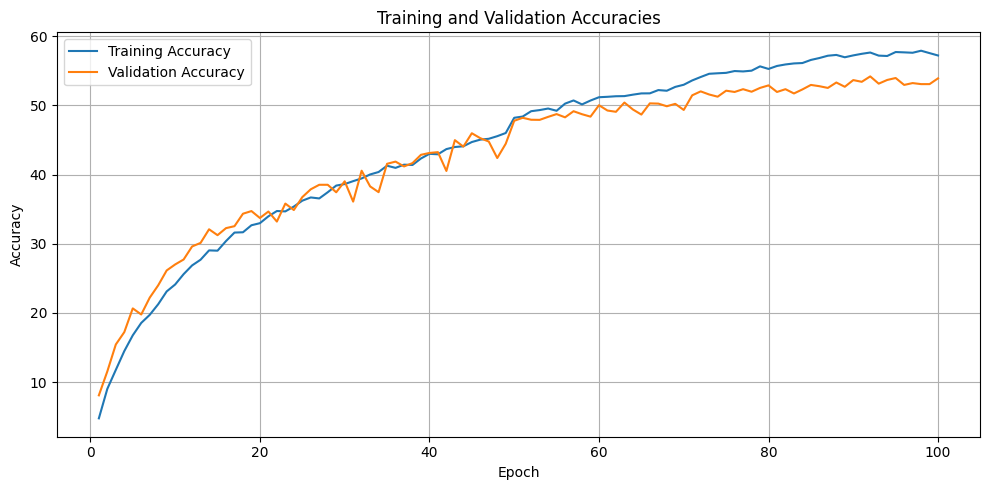

In [28]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()